In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
## Import the data
df = pd.read_csv('../data/historical_data/master_historical_data.csv', index_col = 0)

### Check to see which variables are potentially useful by looking at which ones correlate

,duration,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,visibility,pressure
duration,1.000000,-0.038935,-0.038933,0.130710,0.129765,0.066775,-0.084797,0.014223,0.055319,-0.009969
precipIntensity,-0.038935,1.000000,0.999999,-0.012987,-0.009183,0.140062,0.281057,0.005925,-0.360171,-0.175204
precipProbability,-0.038933,0.999999,1.000000,-0.012999,-0.009194,0.140053,0.281061,0.005913,-0.360173,-0.175201
temperature,0.130710,-0.012987,-0.012999,1.000000,0.998369,0.835453,-0.074700,0.002403,0.011666,-0.326526
apparentTemperature,0.129765,-0.009183,-0.009194,0.998369,1.000000,0.846673,-0.054686,-0.011551,0.000691,-0.325022
dewPoint,0.066775,0.140062,0.140053,0.835453,0.846673,1.000000,0.453420,-0.163121,-0.292505,-0.334033
humidity,-0.084797,0.281057,0.281061,-0.074700,-0.054686,0.453420,1.000000,-0.353514,-0.586213,-0.085404
windSpeed,0.014223,0.005925,0.005913,0.002403,-0.011551,-0.163121,-0.353514,1.000000,0.255663,-0.195192
visibility,0.055319,-0.360171,-0.360173,0.011666,0.000691,-0.292505,-0.586213,0.255663,1.000000,0.148218
pressure,-0.009969,-0.175204,-0.175201,-0.326526,-0.325022,-0.334033,-0.085404,-0.195192,0.148218,1.000000


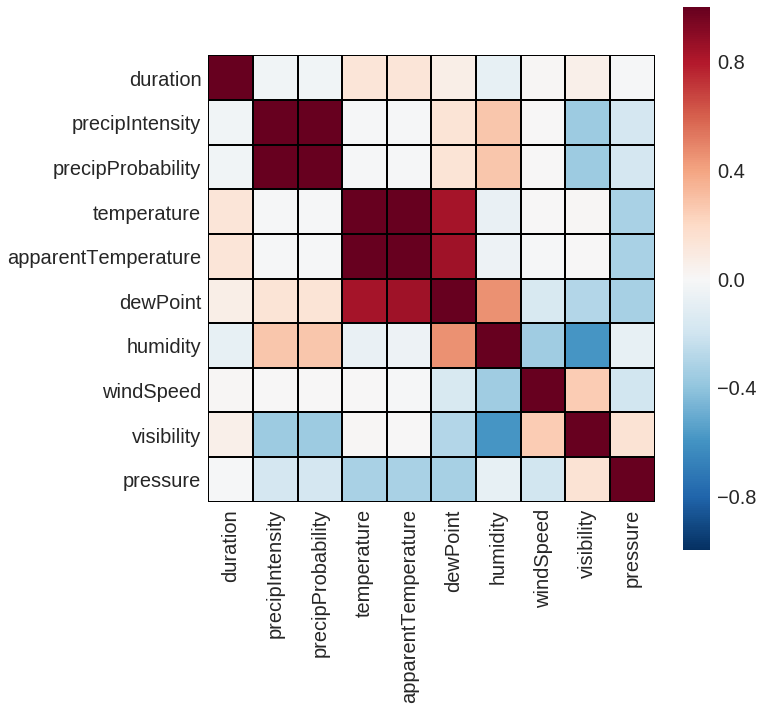

In [5]:
## See how our continuous variables correlate after dropping precipIntensity nulls since they correspond to entries where no weather data was available
df_corrs = df[['duration', 'precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 'visibility', 
               'pressure']].loc[df.precipIntensity.isnull() == False].corr(method = 'spearman')
plt.figure(figsize = [10, 10])
sns.set(font_scale = 2)
sns.heatmap(df_corrs, xticklabels=df_corrs.columns.values, yticklabels=df_corrs.columns.values, square = True, linewidths = 1, linecolor = 'k')
df_corrs

In [6]:
## It looks like there are a few cases of correlation between potential features:
## precipIntensity and precipProbability are highly correlated as would be expected. I will use precipIntensity.
## Same for temperature and apparentTemperature. I will use apparentTemperature.
## Dew point is also correlated with temperature, but it is unlikely to influence ridership simply due to what it measures.
## Humidity, however, is a feature related to dew point that, while correlated with precipitation and visibility, may have a psychological impact on the choice to ride.
## We saw above that windSpeed is only slightly correlated with some other variables, so we will use it.
## It's hard to see how visibility would affect ridership since it seems like the effects of visibility are captured in other features like precipitation/humidity.
## Same for pressure.
## So we will initially use precipIntensity, apparentTemperature, humidity, and windSpeed as our continuous weather features.
## Our categorical features will initially be precipType, working_day, hour, and month.
## We'll also look at how ridership varies between classes of users (registered vs. casual users)

In [7]:
########### Data normalization procedure for variables with uneven group sizes #############
## 1) Group by random variable, hour, variable of choice and count
## 2) Subset df by date, hour, and variable of choice and get uniques and then do the above command on this subset
## Divide 1) by 2)
####### EXAMPLE #######
df_grouped = df[['hour', 'precipType', 'start_date']].groupby(['hour', 'precipType'], as_index = False).count()
df_grouped_2 = df[['hour', 'precipType', 'start_date']].drop_duplicates().groupby(['hour', 'precipType'], as_index = False).count()
df_grouped.set_index(['hour', 'precipType'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'precipType'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.head()

start_date
hour precipType            
0    none         70.084056
     rain         45.179931
     snow         14.941176
1    none         41.721055
     rain         26.934066

### Ridership by working_day and hour

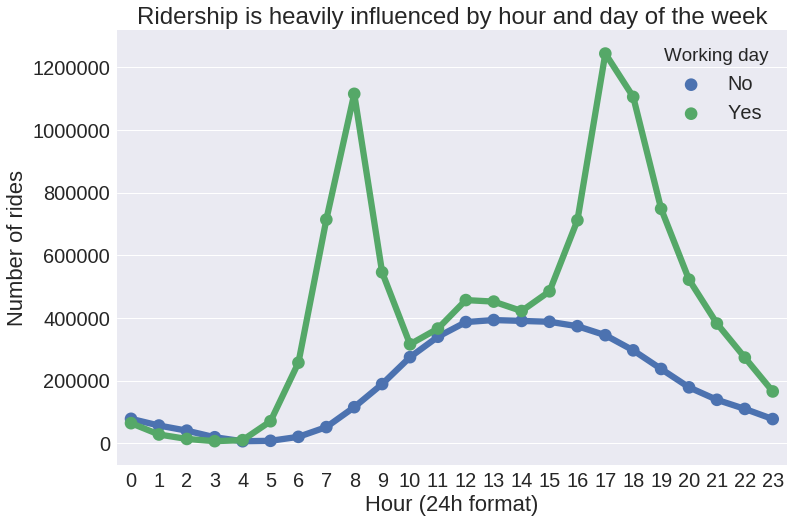

In [8]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['working_day', 'hour', 'holiday']].groupby(['working_day', 'hour'], as_index = False).count()
df_grouped.columns = ['Working day', 'Hour (24h format)', 'Number of rides']
df_grouped['Working day'] = df_grouped['Working day'].apply(lambda x: 'Yes' if x == 1 else 'No')
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
# sns.set_context(font_scale=2)
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides', data = df_grouped, hue = 'Working day', markers = '.', scale = 2)
plt.ylabel('Number of rides')
plt.title('Ridership is heavily influenced by hour and day of the week')

### Ridership varies between user type

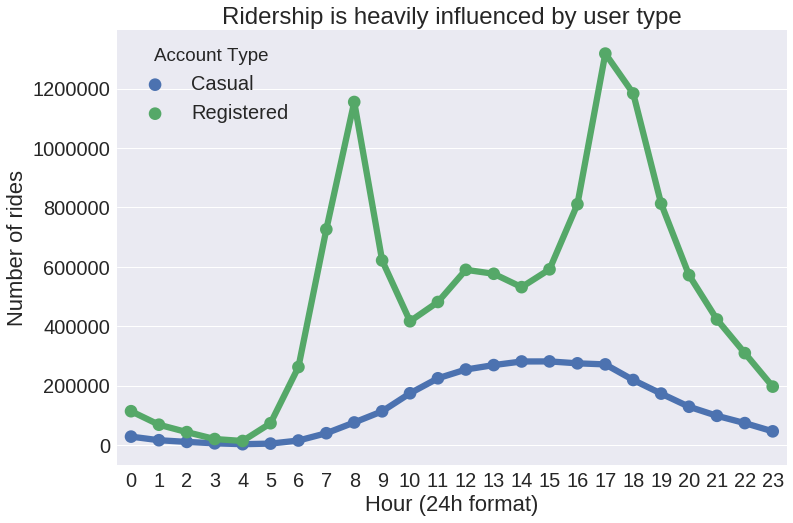

In [9]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['account_type', 'hour', 'holiday']].groupby(['account_type', 'hour'], as_index = False).count()
df_grouped.columns = ['Account Type', 'Hour (24h format)', 'Number of rides']
df_grouped['Account Type'] = df_grouped['Account Type'].apply(lambda x: 'Registered' if x == 1 else 'Casual')
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
# sns.set_context(font_scale=2)
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides', data = df_grouped, hue = 'Account Type', markers = '.', scale = 2)
plt.ylabel('Number of rides')
plt.title('Ridership is heavily influenced by user type')

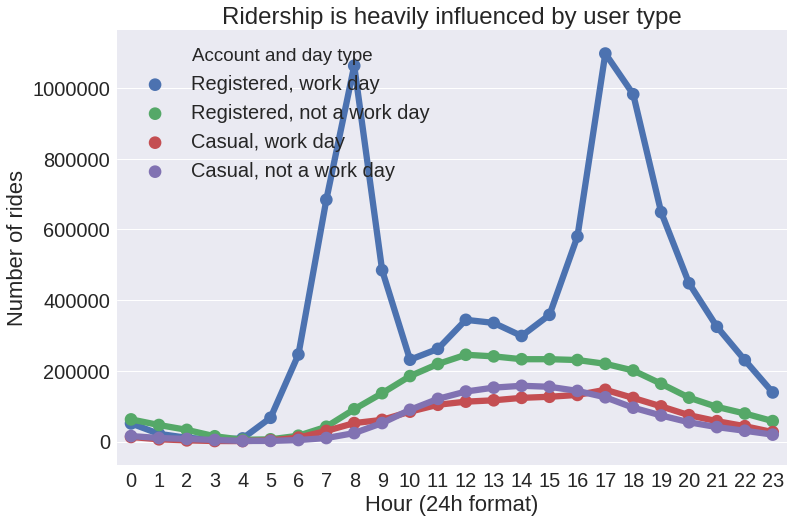

In [10]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['account_type', 'hour', 'holiday', 'working_day']].groupby(['account_type', 'hour', 'working_day'], as_index = False).count()
df_grouped.columns = ['Account type', 'Hour (24h format)', 'Working day', 'Number of rides']
df_grouped['Account type'] = df_grouped['Account type'].apply(lambda x: 'Registered' if x == 1 else 'Casual')
df_grouped['Working day'] = df_grouped['Working day'].apply(lambda x: 'work day' if x == 1 else 'not a work day')
df_grouped['Account and day type'] = df_grouped.apply(lambda x: x['Account type'] + ', ' + x['Working day'], axis = 1)
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
# sns.set_context(font_scale=2)
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides', data = df_grouped, hue = 'Account and day type', markers = '.', scale = 2, 
              hue_order = ['Registered, work day', 'Registered, not a work day', 'Casual, work day', 'Casual, not a work day'])
plt.ylabel('Number of rides')
plt.title('Ridership is heavily influenced by user type')

In [11]:
## Registered users have drastic usage changes depending on the day type, while casual users do not.
## Registered users act like casual users when it is not a working day.
## The network of bikes is mainly used for traveling to and from work (presumably).

### Ridership by month

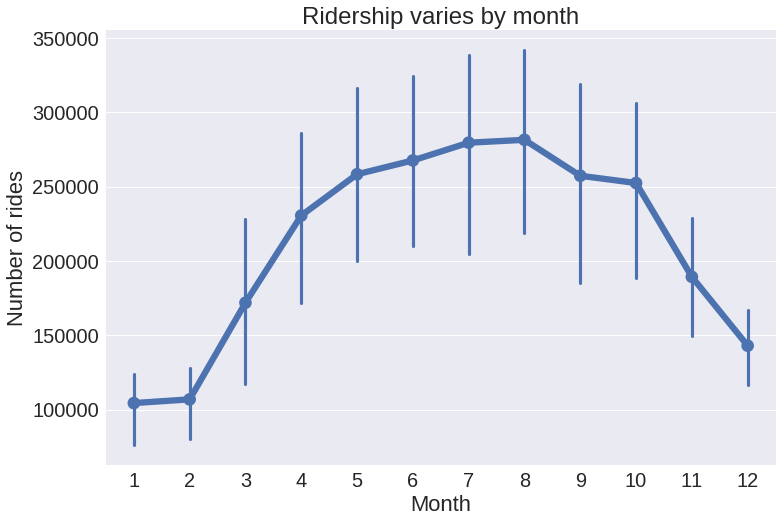

In [12]:
## Plot rides by season
## Group by working day and hour and do a count.
df_grouped = df[['month', 'year', 'holiday']].groupby(['month', 'year'], as_index = False).count()
df_grouped.columns = ['Month', 'Year', 'Number of rides']
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Month', y = 'Number of rides', data = df_grouped, markers = '.', scale = 2)
plt.ylabel('Number of rides')
plt.title('Ridership varies by month')

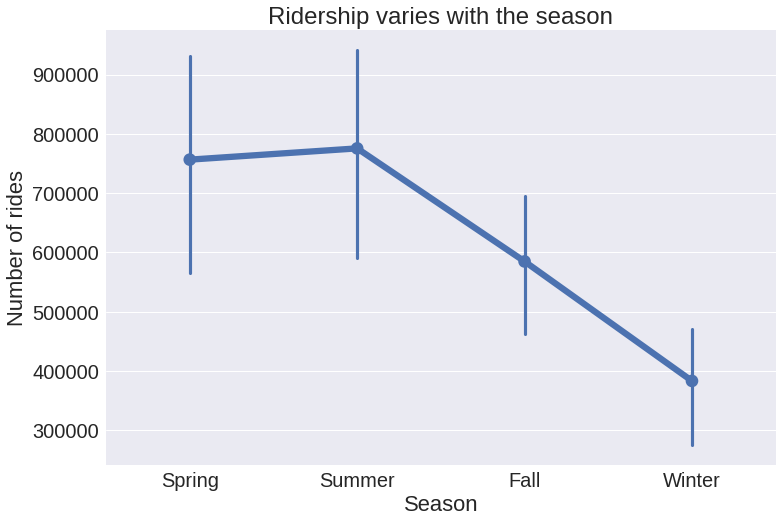

In [13]:
## Plot rides by season
## Group by working day and hour and do a count.
df_grouped = df[['season', 'year', 'holiday']].groupby(['season', 'year'], as_index = False).count()
df_grouped.columns = ['Season', 'Year', 'Number of rides']
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Season', y = 'Number of rides', data = df_grouped, markers = '.', scale = 2, order = ['Spring', 'Summer', 'Fall', 'Winter'])
plt.ylabel('Number of rides')
plt.title('Ridership varies with the season')

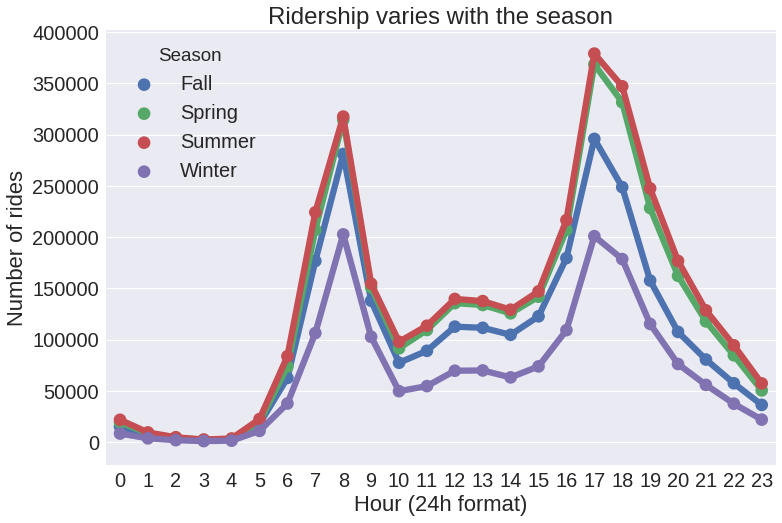

In [14]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['working_day', 'hour', 'season', 'holiday']].groupby(['working_day', 'hour', 'season'], as_index = False).count()
df_grouped.columns = ['Working day', 'Hour (24h format)', 'Season', 'Number of rides']
df_grouped['Working day'] = df_grouped['Working day'].apply(lambda x: 'Yes' if x == 1 else 'No')
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides', data = df_grouped.loc[df_grouped['Working day'] == 'Yes'], hue = 'Season', markers = '.', scale = 2)
plt.ylabel('Number of rides')
plt.title('Ridership varies with the season')

In [15]:
## Interestingly, the change in seasons does not affect the morning rides to work as much as it does the evening rides from work

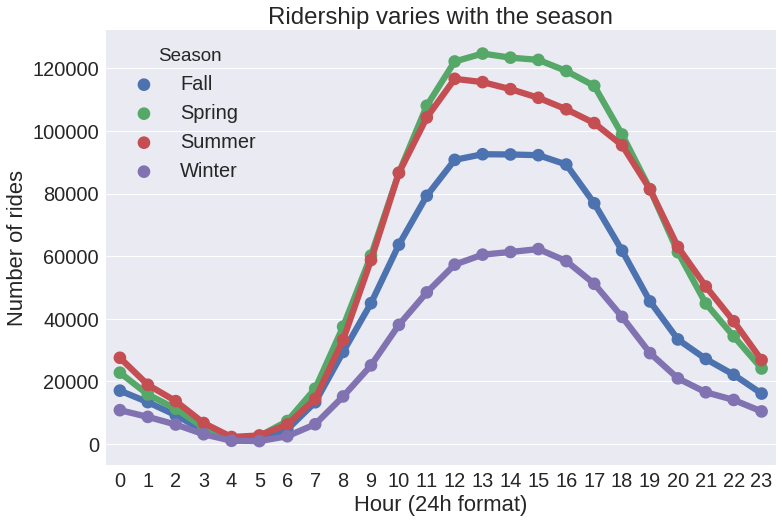

In [16]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['working_day', 'hour', 'season', 'holiday']].groupby(['working_day', 'hour', 'season'], as_index = False).count()
df_grouped.columns = ['Working day', 'Hour (24h format)', 'Season', 'Number of rides']
df_grouped['Working day'] = df_grouped['Working day'].apply(lambda x: 'Yes' if x == 1 else 'No')
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides', data = df_grouped.loc[df_grouped['Working day'] == 'No'], hue = 'Season', markers = '.', scale = 2)
plt.ylabel('Number of rides')
plt.title('Ridership varies with the season')

### Ridership by precipitation intensity

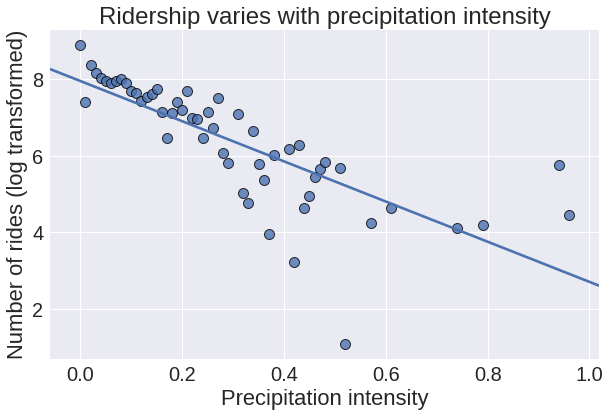

In [17]:
# fig = plt.figure(figsize = [12, 6], facecolor = 'white')
# ax = plt.subplot(1,1,1)
sns.set(font_scale=2)

def quintiles(row):
    if row < 0.01:
        return 0
    else:
        for each in range(0,100,1):
            if row > each/100. and row <= each/100.+0.01:
                return each/100.+0.01

df['precipIntensityQuintiles'] = df.precipIntensity.apply(quintiles)
df_grouped = df[['hour', 'precipIntensityQuintiles', 'start_date']].groupby(['precipIntensityQuintiles', 'hour'], 
                                                                            as_index = False).count()
df_grouped_2 = df[['hour', 'precipIntensityQuintiles', 'start_date']].drop_duplicates().groupby(['hour', 
                                                                                                 'precipIntensityQuintiles'], 
                                                                                                 as_index = False).count()
df_grouped.set_index(['hour', 'precipIntensityQuintiles'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'precipIntensityQuintiles'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Precipitation intensity', 'Number of rides']
df_grouped = df_grouped.drop('Hour (24h format)', axis = 1).groupby('Precipitation intensity', as_index = False).sum()
df_grouped['Number of rides (log transformed)'] = df_grouped['Number of rides'].apply(np.log)

sns.lmplot(x = 'Precipitation intensity', y = 'Number of rides (log transformed)', data = df_grouped, palette = 'RdBu_r', 
           markers = 'o', ci = 0,
           fit_reg = True, legend = False, scatter_kws={'linewidths':1,'edgecolor':'k', 's': 100}, size = 6, aspect = 1.5)
plt.title('Ridership varies with precipitation intensity')

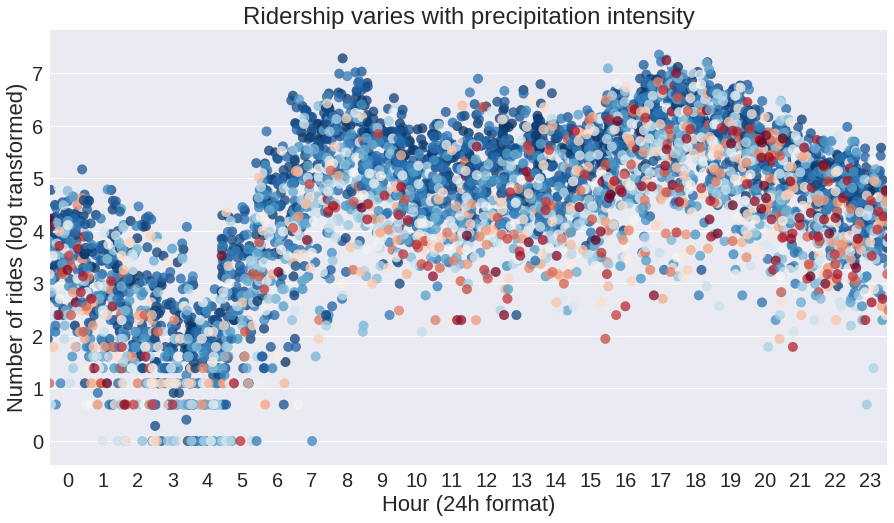

In [18]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['hour', 'precipIntensity', 'start_date']].groupby(['precipIntensity', 'hour'], as_index = False).count()
df_grouped_2 = df[['hour', 'precipIntensity', 'start_date']].drop_duplicates().groupby(['hour', 'precipIntensity'], 
                                                                                       as_index = False).count()
df_grouped.set_index(['hour', 'precipIntensity'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'precipIntensity'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Precipitation intensity', 'Number of rides']
df_grouped['Number of rides (log transformed)'] = df_grouped['Number of rides'].apply(np.log)

sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
fig = plt.figure(figsize = [15, 8])
ax1 = sns.stripplot(x = 'Hour (24h format)', y = 'Number of rides (log transformed)', data = df_grouped, jitter = 0.6, 
                    hue = 'Precipitation intensity', palette = 'RdBu_r', alpha = 0.75, size = 10)

ax1.legend_.remove()
ax1.set_ylabel('Number of rides (log transformed)')
plt.title('Ridership varies with precipitation intensity')

### Ridership by precipitation type

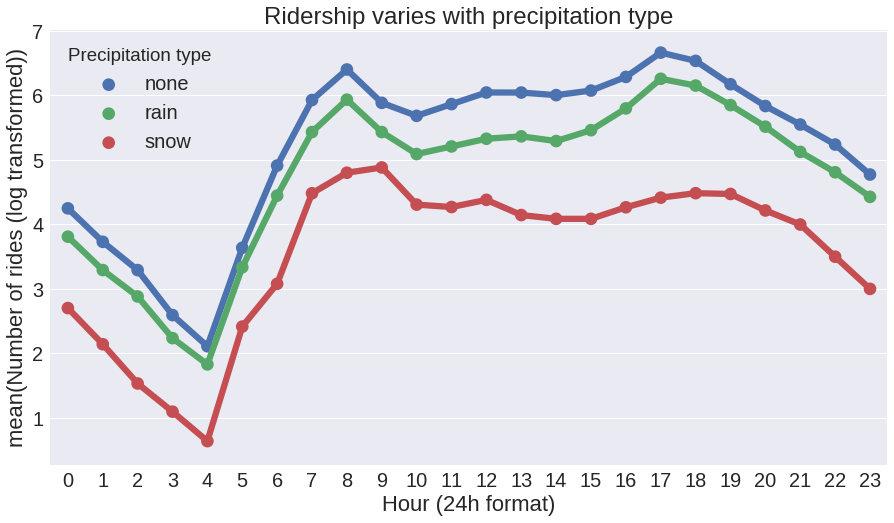

In [19]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['hour', 'precipType', 'holiday']].groupby(['precipType', 'hour'], as_index = False).count()

df_grouped = df[['hour', 'precipType', 'start_date']].groupby(['precipType', 'hour'], as_index = False).count()
df_grouped_2 = df[['hour', 'precipType', 'start_date']].drop_duplicates().groupby(['hour', 'precipType'], as_index = False).count()
df_grouped.set_index(['hour', 'precipType'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'precipType'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)

df_grouped.columns = ['Hour (24h format)', 'Precipitation type', 'Number of rides']
df_grouped['Number of rides (log transformed)'] = df_grouped['Number of rides'].apply(np.log)

sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
fig = plt.figure(figsize = [15, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides (log transformed)', data = df_grouped, hue = 'Precipitation type', 
              markers = '.', scale = 2)
# ax1 = sns.stripplot(x = 'Hour (24h format)', y = 'Number of rides (log transformed)', data = df_grouped, jitter = 0.6, 
#                     hue = 'Precipitation type', size = 10)
ax1.set_ylabel('Number of rides (log transformed)')
plt.title('Ridership varies with precipitation type')

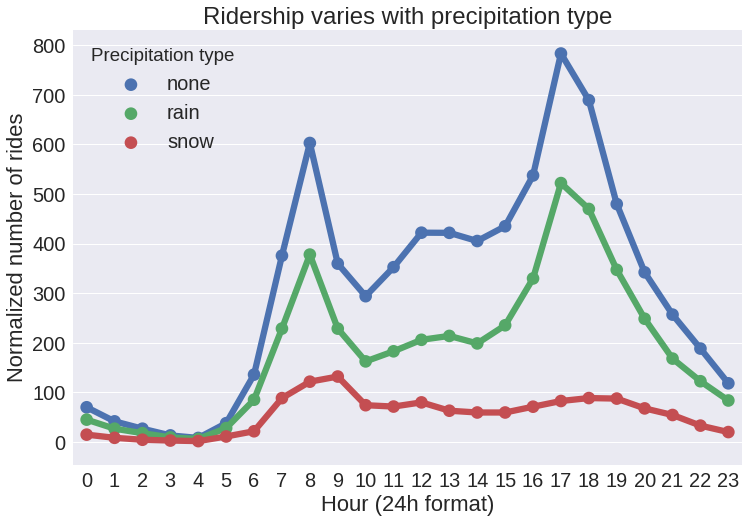

In [20]:
## Plot the number of rides per hour for different weather conditions
## Group by working day and hour and do a count.
df_grouped = df[['hour', 'precipType', 'start_date']].groupby(['hour', 'precipType'], as_index = False).count()
df_grouped_2 = df[['hour', 'precipType', 'start_date']].drop_duplicates().groupby(['hour', 'precipType'], as_index = False).count()
df_grouped.set_index(['hour', 'precipType'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'precipType'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Precipitation type', 'Number of rides']
## Plot
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
plt.figure(figsize = [12, 8])
sns.pointplot(x = 'Hour (24h format)', y = 'Number of rides', data = df_grouped, hue = 'Precipitation type', markers = '.', 
              scale = 2)
plt.ylabel('Normalized number of rides')
plt.title('Ridership varies with precipitation type')

In [21]:
## Rain has a modest negative effect on ridership, while snow has a large negative effect

### Ridership by temperature

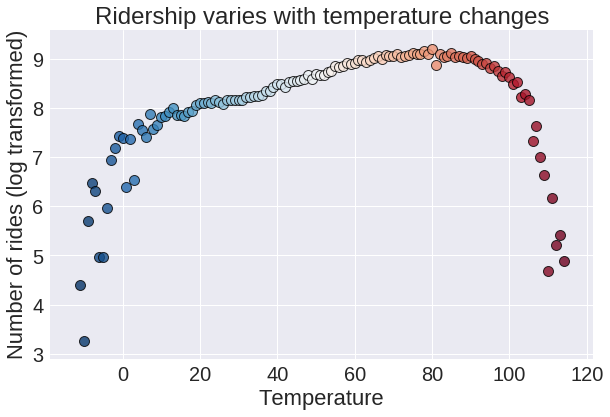

In [22]:
sns.set(font_scale=2)
sns.set_context({'figure.facecolor': 'white'})
df_grouped = df[['hour', 'apparentTemperatureRounded', 'start_date']].groupby(['apparentTemperatureRounded', 'hour'], 
                                                                       as_index = False).count()
df_grouped_2 = df[['hour', 'apparentTemperatureRounded', 
                   'start_date']].drop_duplicates().groupby(['hour', 'apparentTemperatureRounded'], as_index = False).count()
df_grouped.set_index(['hour', 'apparentTemperatureRounded'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'apparentTemperatureRounded'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Temperature', 'Number of rides']
df_grouped = df_grouped.drop('Hour (24h format)', axis = 1).groupby('Temperature', as_index = False).sum()
df_grouped['Number of rides (log transformed)'] = df_grouped['Number of rides'].apply(np.log)
sns.lmplot(x = 'Temperature', y = 'Number of rides (log transformed)', data = df_grouped, palette = 'RdBu_r', markers = 'o', 
           hue = 'Temperature', 
           fit_reg = False, legend = False, scatter_kws={'linewidths':1,'edgecolor':'k', 's': 100}, size = 6, aspect = 1.5, )
plt.title('Ridership varies with temperature changes')

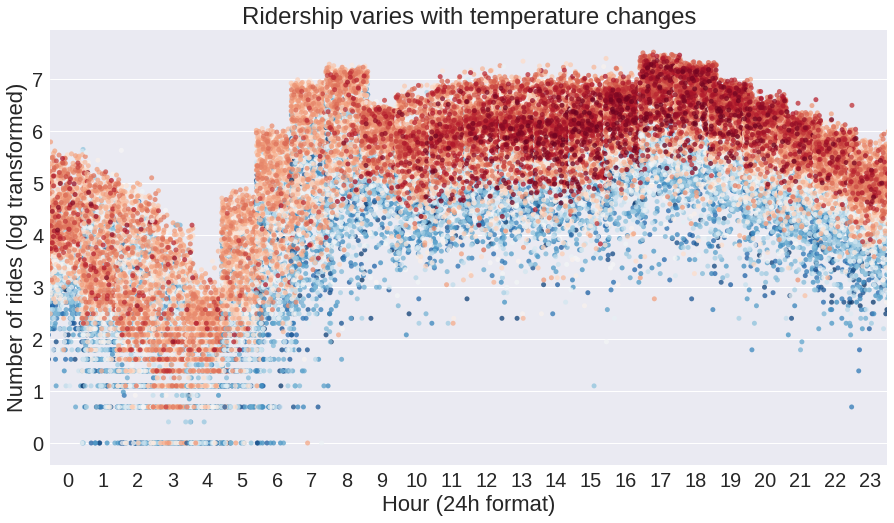

In [23]:
## Plot the number of rides per hour for working days and non-working days
## Group by working day and hour and do a count.
df_grouped = df[['hour', 'apparentTemperature', 'start_date']].groupby(['apparentTemperature', 'hour'], 
                                                                       as_index = False).count()
df_grouped_2 = df[['hour', 'apparentTemperature', 'start_date']].drop_duplicates().groupby(['hour', 'apparentTemperature'], 
                                                                                           as_index = False).count()
df_grouped.set_index(['hour', 'apparentTemperature'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'apparentTemperature'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Temperature', 'Number of rides']
df_grouped['Number of rides (log transformed)'] = df_grouped['Number of rides'].apply(np.log)
sns.set(font_scale = 2)
sns.set_context({'figure.facecolor': 'white'})
fig = plt.figure(figsize = [15, 8])
ax1 = sns.stripplot(x = 'Hour (24h format)', y = 'Number of rides (log transformed)', data = df_grouped, jitter = 0.6, 
                    hue = 'Temperature', palette = 'RdBu_r', alpha = 0.75, size = 5)
ax1.legend_.remove()
ax1.set_ylabel('Number of rides (log transformed)')
plt.title('Ridership varies with temperature changes')

In [24]:
## Ridership increases with increasing temperature until about 80 degrees F, at which point it starts to decrease.
## At very low or high temperatures (<0 or >100 degrees F) ridership falls off drastically.

### Ridership by wind speed

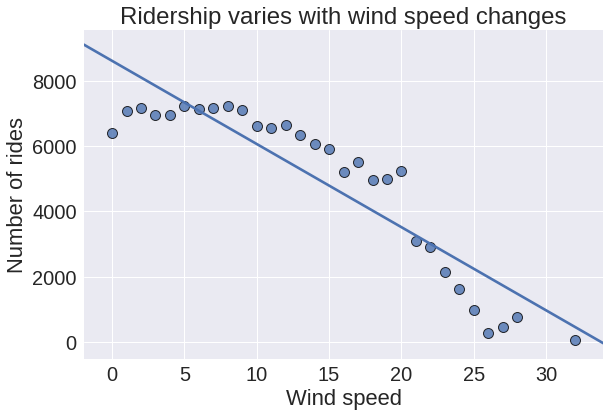

In [25]:
# fig = plt.figure(figsize = [12, 6], facecolor = 'white')
# ax = plt.subplot(1,1,1)
sns.set(font_scale=2)
sns.set_context({'figure.facecolor': 'white'})

df_grouped = df[['hour', 'windSpeedRounded', 'start_date']].groupby(['windSpeedRounded', 'hour'], 
                                                                       as_index = False).count()
df_grouped_2 = df[['hour', 'windSpeedRounded', 'start_date']].drop_duplicates().groupby(['hour', 'windSpeedRounded'], 
                                                                                           as_index = False).count()
df_grouped.set_index(['hour', 'windSpeedRounded'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'windSpeedRounded'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Wind speed', 'Number of rides']
df_grouped = df_grouped.drop('Hour (24h format)', axis = 1).groupby('Wind speed', as_index = False).sum()
sns.lmplot(x = 'Wind speed', y = 'Number of rides', data = df_grouped, palette = 'RdBu_r', markers = 'o', fit_reg = True, ci = 0, 
           legend = False, scatter_kws={'linewidths':1,'edgecolor':'k', 's': 100}, size = 6, aspect = 1.5)
plt.title('Ridership varies with wind speed changes')

In [28]:
## Wind speed has little effect on ridership when the wind is mild (<10 mph).
## Between 10 and 20 mph ridership decreases modestly, and above 20 mph ridership drastically falls off.

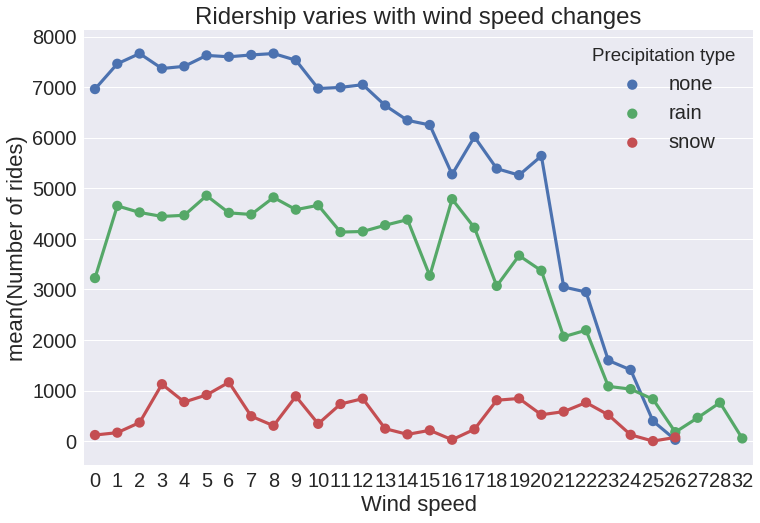

In [29]:
fig = plt.figure(figsize = [12, 8])
sns.set(font_scale=2)
sns.set_context({'figure.facecolor': 'white'})

df_grouped = df[['hour', 'windSpeedRounded', 'start_date', 'precipType']].groupby(['windSpeedRounded', 'hour', 'precipType'], 
                                                                       as_index = False).count()
df_grouped_2 = df[['hour', 'windSpeedRounded', 'start_date', 'precipType']].drop_duplicates().groupby(['hour', 
                                                                                                       'windSpeedRounded', 
                                                                                                       'precipType'], 
                                                                                                      as_index = False).count()
df_grouped.set_index(['hour', 'windSpeedRounded', 'precipType'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'windSpeedRounded', 'precipType'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Wind speed', 'Precipitation type', 'Number of rides']
df_grouped = df_grouped.drop('Hour (24h format)', axis = 1).groupby(['Wind speed', 'Precipitation type'], as_index = False).sum()
df_grouped['Wind speed'] = df_grouped['Wind speed'].astype(int)

sns.pointplot(x = 'Wind speed', y = 'Number of rides', data = df_grouped, markers = 'o', hue = 'Precipitation type', 
           fit_reg = False, legend = True, scatter_kws={'linewidths':1,'edgecolor':'k', 's': 100}, size = 6, aspect = 1.5, )
plt.title('Ridership varies with wind speed changes')

In [30]:
## High wind speed doesn't influence ridership much when it is snowing, but it does in the other scenarios.

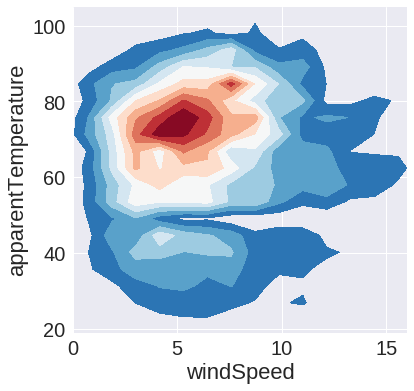

In [78]:
sns.set(font_scale=2)
sns.set_context({'figure.facecolor': 'white'})
df_kde = df[['windSpeed', 'apparentTemperature']].dropna()
plt.figure(figsize = [6,6])
plt.xlim(0, 16)
plt.ylim(19, 105)
ax = sns.kdeplot(df_kde.windSpeed, df_kde.apparentTemperature, shade=True, shade_lowest=False, cmap = 'RdBu_r', gridsize = 30)

In [1]:
## High winds are associated with lower ridership univerally.
## It kind of looks like when it's hot and there's a breeze ridership increases over it just being hot without a breeze, but that's not a strong visual signal.

### Ridership varies with humidity

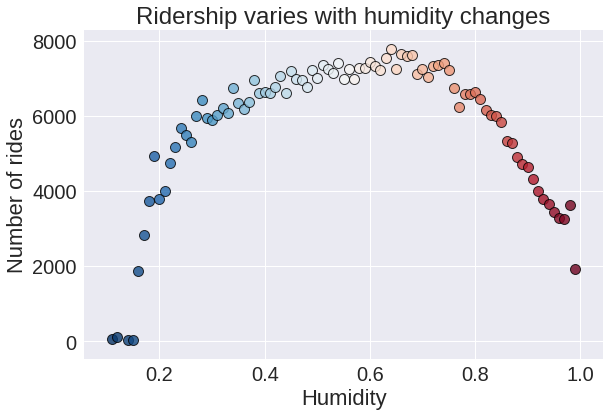

In [82]:
# fig = plt.figure(figsize = [12, 6], facecolor = 'white')
# ax = plt.subplot(1,1,1)
sns.set(font_scale=2)
sns.set_context({'figure.facecolor': 'white'})

df_grouped = df[['hour', 'humidity', 'start_date']].groupby(['humidity', 'hour'], 
                                                                       as_index = False).count()
df_grouped_2 = df[['hour', 'humidity', 'start_date']].drop_duplicates().groupby(['hour', 'humidity'], 
                                                                                           as_index = False).count()
df_grouped.set_index(['hour', 'humidity'], drop = True, inplace = True)
df_grouped_2.set_index(['hour', 'humidity'], drop = True, inplace = True)
df_grouped /= df_grouped_2
df_grouped.reset_index(inplace = True)
df_grouped.columns = ['Hour (24h format)', 'Humidity', 'Number of rides']
df_grouped = df_grouped.drop('Hour (24h format)', axis = 1).groupby('Humidity', as_index = False).sum()
sns.lmplot(x = 'Humidity', y = 'Number of rides', data = df_grouped, palette = 'RdBu_r', markers = 'o', fit_reg = False, ci = 0, hue = 'Humidity',
           legend = False, scatter_kws={'linewidths':1,'edgecolor':'k', 's': 100}, size = 6, aspect = 1.5)
plt.title('Ridership varies with humidity changes')

In [83]:
## Ridership is highest at moderate humidity levels

In [89]:
## We've already done some feature pruning by assessing the degree to which certain features are correlated, so we'll go from there.
## Make a subset with just the data we care about (continuous features: precipIntensity, apparentTemperature, humidity, windSpeed; categorical features: precipType, working_day, hour, month)
df_sub = df[['start_datetime', 'precipIntensity', 'apparentTemperature', 'humidity', 'windSpeed', 'precipType', 'working_day', 'hour', 'month']].copy()
## Set the index as the datetime of the ride
df_sub.set_index('start_datetime', inplace = True, drop = True)
df_sub.index = pd.to_datetime(df_sub.index)
df_sub.sort_index(inplace = True)
df_sub.head()

,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month
start_datetime,,,,,,,,
2011-01-01 00:01:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:02:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:06:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:09:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:28:00,0.0,31.1,0.82,4.88,none,0,0,1


In [90]:
print df_sub.shape
print df_sub.isnull().sum()

(15000336, 8)
precipIntensity         271
apparentTemperature     271
humidity                271
windSpeed              1448
precipType                0
working_day               0
hour                      0
month                     0
dtype: int64


In [91]:
## Since there are so few nulls we will just drop them
df_sub.dropna(inplace = True)

In [92]:
## We need to label encode the categoricals. The only one that hasn't already been done is precipType, so we'll do that here.
## Get all the different precip types
precipType_labels = df_sub.precipType.unique().tolist()
## Instantiate the encoder
precipType_label_encoder = {}
## Assign a unique integer for each precip type
for i, label in enumerate(precipType_labels):
    precipType_label_encoder[str(label)] = int(i)
print precipType_label_encoder
## Encode the labels
df_sub['precipType'] = df_sub.precipType.apply(lambda x: precipType_label_encoder[x])
df_sub.head()

{'none': 0, 'snow': 2, 'rain': 1}


,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month
start_datetime,,,,,,,,
2011-01-01 00:01:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:02:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:06:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:09:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:28:00,0.0,31.1,0.82,4.88,0,0,0,1


In [93]:
## Now let's bin the data into 10 minute intervals and get ride counts per interval
df_sub.reset_index(inplace = True)
## Bin into 10 minute bins
df_sub['start_datetime'] = df_sub.start_datetime.apply(lambda x: x - datetime.timedelta(minutes = x.minute % 10))
## Groupby datetime and get counts (number of rides)
df_sub_rides = df_sub[['start_datetime', 'hour']].groupby('start_datetime', as_index = False).count()
df_sub_rides.columns = ['start_datetime', 'rides']
## Get the first instance of a bin and set that as the data for joining
df_sub_first = df_sub.groupby('start_datetime', as_index = False).first()
## Join on datetime
df_sub = df_sub_rides.merge(df_sub_first, on = 'start_datetime', how = 'left')

In [94]:
## Let's fill in the bins that are missing
## Make a date range
date_range = pd.date_range(start = df_sub.start_datetime.iloc[0], end = df_sub.start_datetime.iloc[-1], freq = '10min')
## Make a df of zeroes with the date range as the index
df_dr = pd.DataFrame([0]*date_range.shape[0], columns=['rides'], index = date_range)
df_dr.reset_index(inplace = True)
df_dr.columns = ['start_datetime', 'rides']
## Join with df_sub
df_sub = df_dr.merge(df_sub, how = 'left', on = 'start_datetime')
## Fill in the time bins without any rides (NaNs in rides_y) with zeroes
df_sub.rides_y.loc[df_sub.rides_y.isnull()] = 0
## Make rides column from rides_y
df_sub['rides'] = df_sub['rides_y']
## Drop rides_x and rides_y
df_sub.drop(['rides_x', 'rides_y'], inplace = True, axis = 1)

In [95]:
## Forward fill weather NaNs
df_sub['precipIntensity'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['apparentTemperature'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['humidity'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['windSpeed'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['precipType'].fillna(method = 'ffill', axis = 0, inplace = True)

In [96]:
## Fill in the hour and month
df_sub['hour'] = df_sub['start_datetime'].apply(lambda x: x.hour)
df_sub['month'] = df_sub['start_datetime'].apply(lambda x: x.month)

In [105]:
## Fill in the working_day
holidays = pd.read_csv('../data/holidays.csv', index_col = 0)
df_sub['working_day'] = df_sub.start_datetime.apply(lambda x: 0 if x.strftime('%Y-%m-%d') in holidays.date.tolist() else 1)

In [110]:
## Save the data to disk
df_sub.set_index('start_datetime', inplace = True, drop = True)
df_sub.to_csv('../data/historical_data_for_models.csv', sep = ',')
df_sub.head()

,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month,rides
start_datetime,,,,,,,,,
2011-01-01 00:00:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0
2011-01-01 00:10:00,0.0,31.1,0.82,4.88,0.0,1,0,1,0.0
2011-01-01 00:20:00,0.0,31.1,0.82,4.88,0.0,1,0,1,1.0
2011-01-01 00:30:00,0.0,31.1,0.82,4.88,0.0,1,0,1,3.0
2011-01-01 00:40:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0


In [112]:
## Import the data
df_sub = pd.read_csv('../data/historical_data_for_models.csv', index_col = 0)
df_sub.index = pd.to_datetime(df_sub.index)
df_sub.head()

,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month,rides
start_datetime,,,,,,,,,
2011-01-01 00:00:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0
2011-01-01 00:10:00,0.0,31.1,0.82,4.88,0.0,1,0,1,0.0
2011-01-01 00:20:00,0.0,31.1,0.82,4.88,0.0,1,0,1,1.0
2011-01-01 00:30:00,0.0,31.1,0.82,4.88,0.0,1,0,1,3.0
2011-01-01 00:40:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0


(35000, 65000)

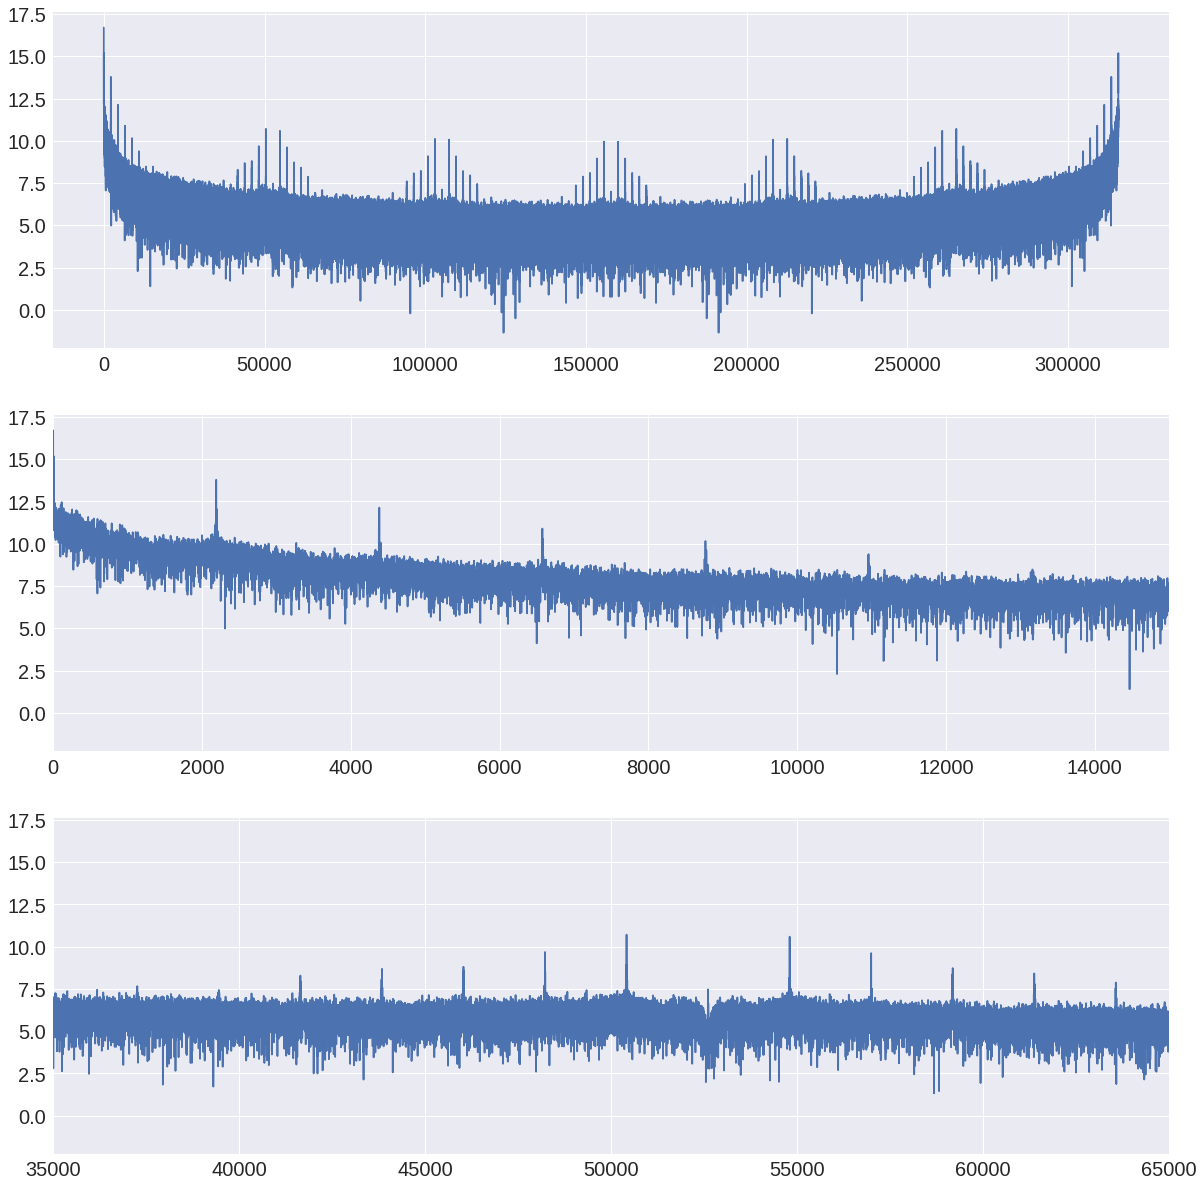

In [113]:
## Since we are dealing with timecourse data we saw that there are periodic trends in the data at various levels: yearly, monthly, weekly, and daily.
## Let's apply an FFT just to have numerical evidence along with our previous visual evidence
plt.figure(figsize = [20,21])
fft = np.fft.fft( df_sub['apparentTemperature'])
plt.subplot(3,1,1)
plt.plot(np.log(np.abs(fft)))
plt.subplot(3,1,2)
plt.plot(np.log(np.abs(fft)))
plt.xlim([-1,15000])
plt.subplot(3,1,3)
plt.plot(np.log(np.abs(fft)))
plt.xlim([35000,65000])

In [114]:
## There is clearly periodicity in the data, as we expected from our visual analysis. We can implement this as one or more features in our models.